Code used to generate many of the figures used in the results section of the writeup

In [2]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import nbinom
import scipy.stats as stats
from scipy.special import gamma
import pandas as pd
import random
from math import comb
import math
from pickle import dump
from tqdm import tqdm
from pickle import load
from tqdm import tqdm

In [3]:
mpl.rc('image', cmap='viridis')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 30}

mpl.rc('font', **font)

# Figure Generation

## Parameter Plots

Produces a plot of the between premises transmission rate against the seasonal forcing term, fitted for each of the tranmission network types.

In [8]:
tau = [0.00110078125,8.8e-4,5.7e-4,0.000425,0.00033]
eps_r =[3.6e-5,4.3e-5,5.775e-5,7.725e-5,9.625e-5]
eps_s = [1.348*eps for eps in eps_r]
eps_s

[4.852800000000001e-05, 5.7964e-05, 7.7847e-05, 0.000104133, 0.000129745]

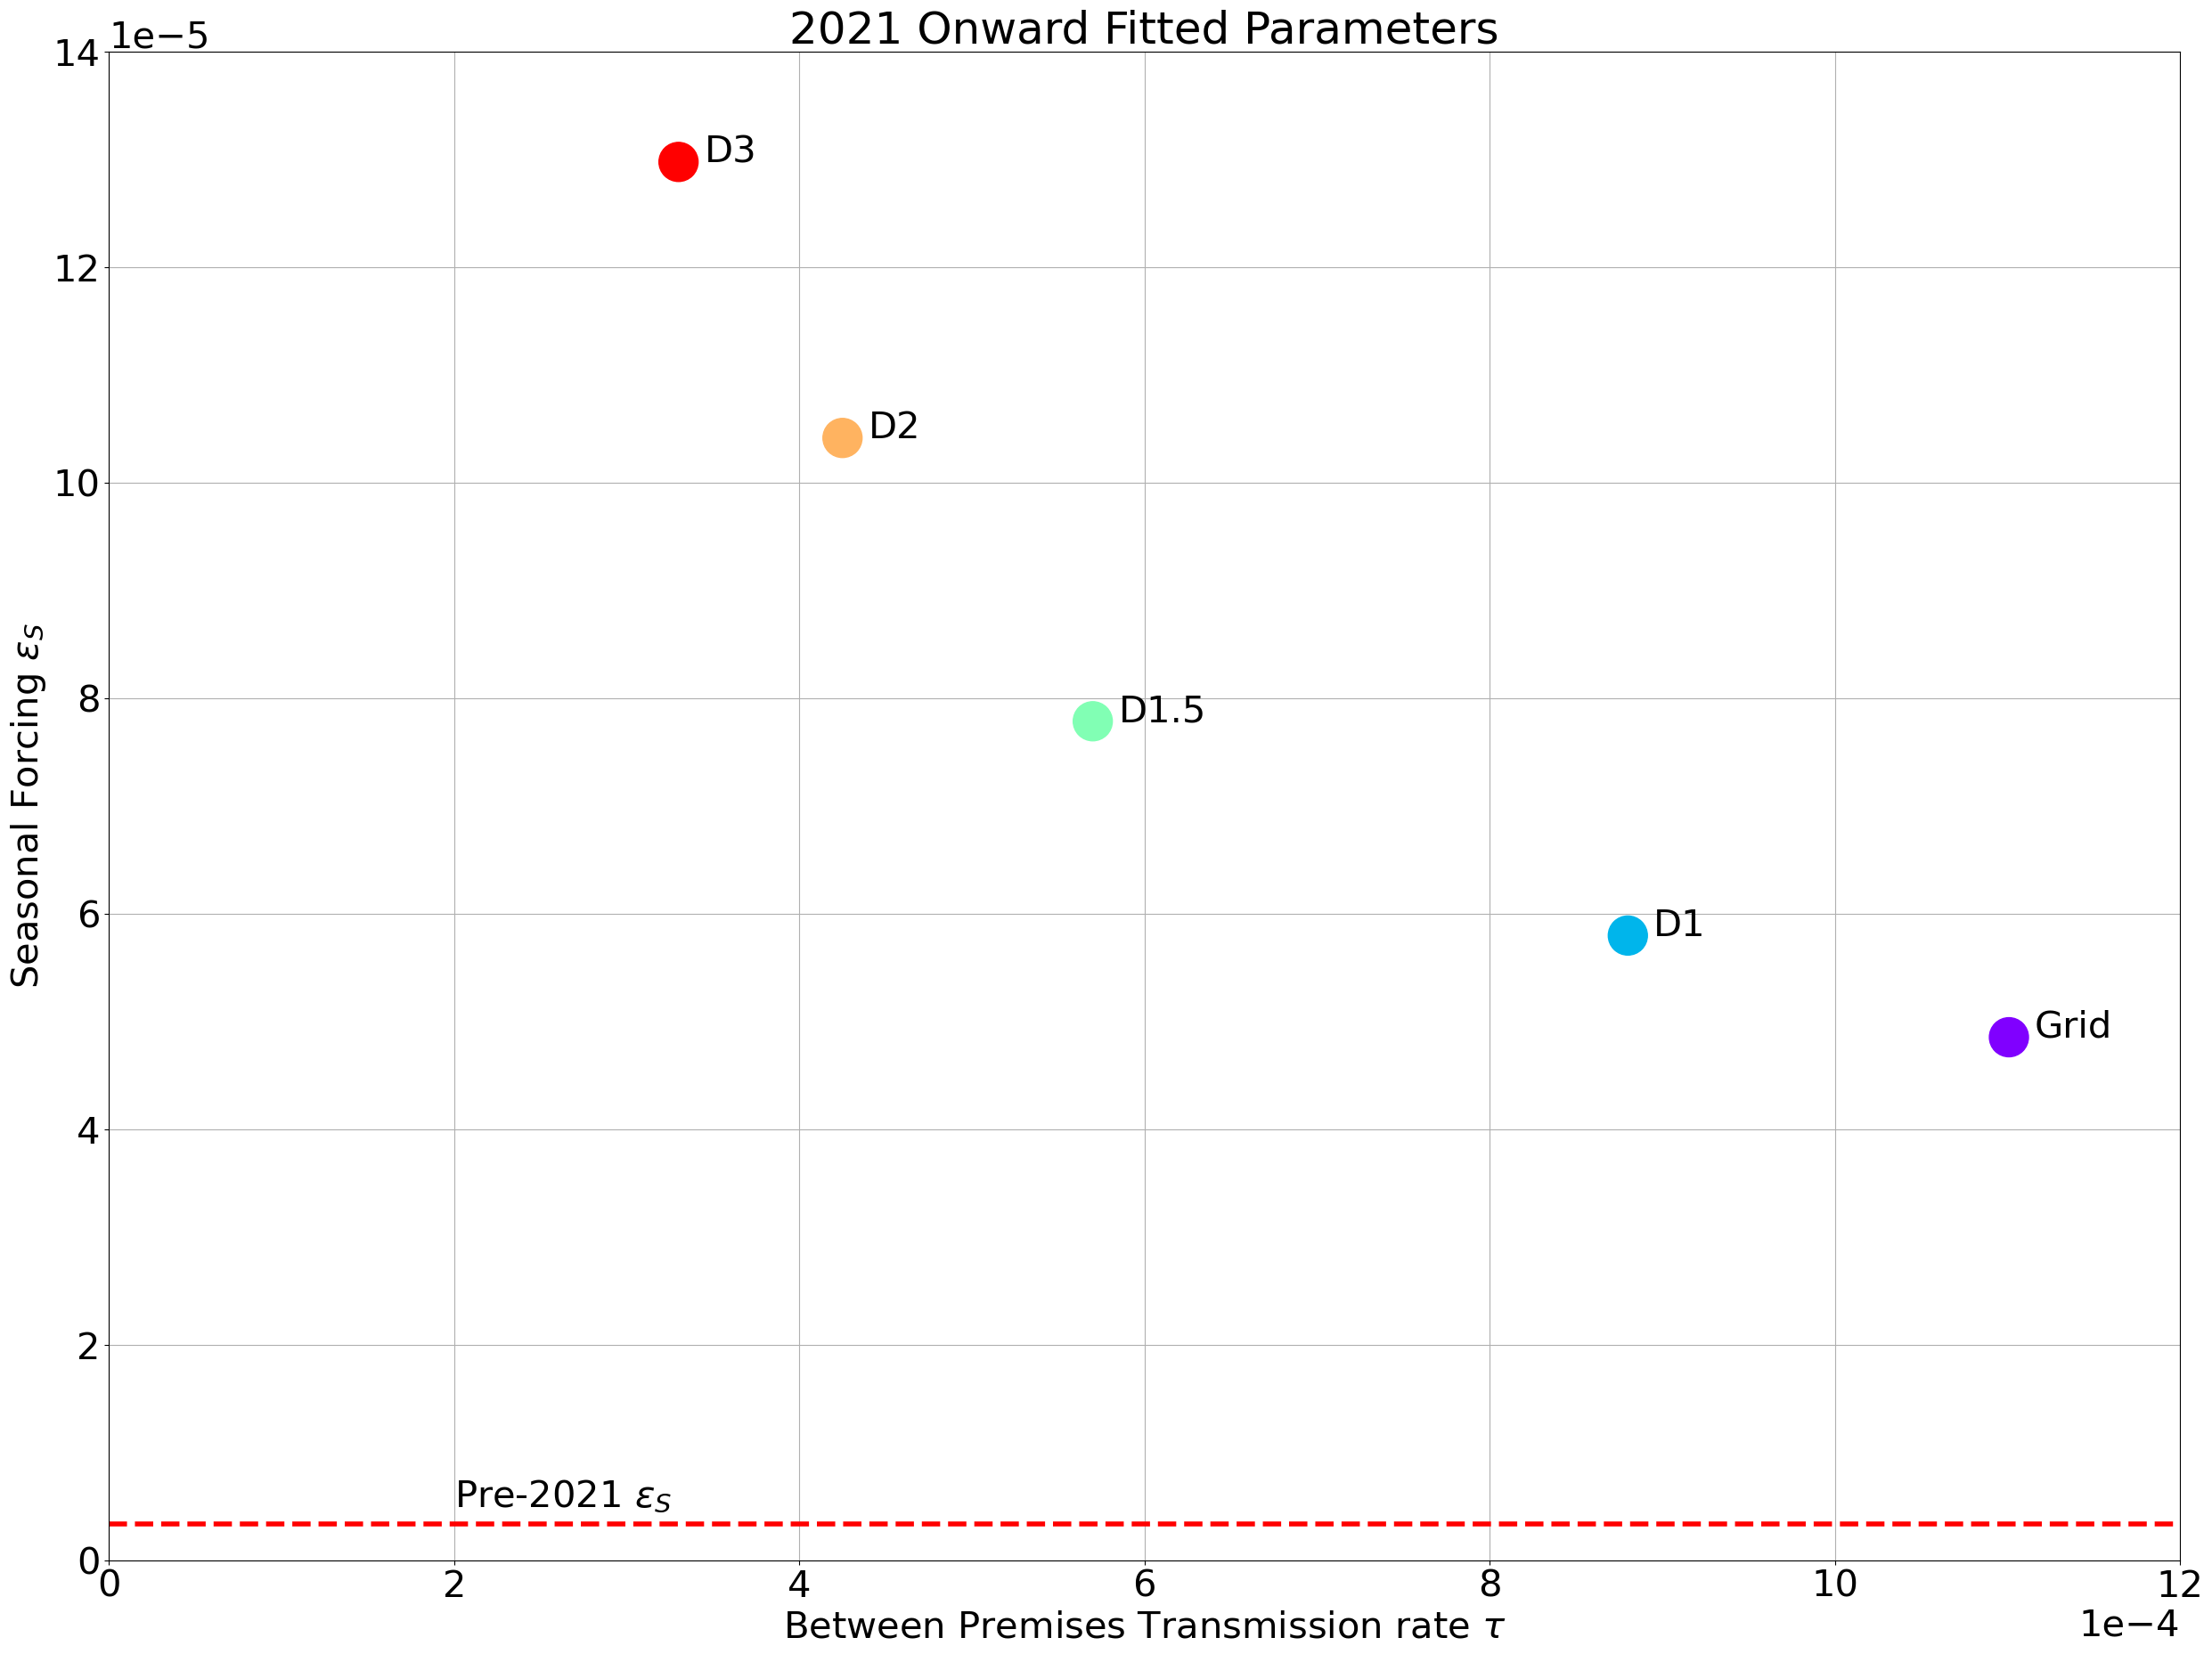

In [7]:
fig, ax = plt.subplots(1,1,figsize = (30,22))
colors = cm.rainbow(np.linspace(0, 1, len(tau)))
ax.scatter(tau, eps_s,c = colors,s=1000)
n = ["Grid","D1","D1.5","D2","D3"]
model = np.poly1d(np.polyfit(np.log(tau), eps_s, 1))
polyline = np.linspace(0, tau[0], 50)

for i, txt in enumerate(n):
    ax.annotate(txt, (tau[i]+1.5e-5, eps_s[i]))
    
ax.annotate(r"$\varepsilon_S = 128.8736 \tau^2 - 0.245975391 \tau + 0.000152$", (2.25e-4+1e-5,model(2.25e-4)))
    
ax.ticklabel_format( axis='x', style='sci',scilimits=(-4,-4))
ax.ticklabel_format( axis='y', style='sci',scilimits=(-5,-5))

ax.set_xlim(0e-4,12e-4)
ax.set_ylim(0e-5,14e-5)

ax.set_xlabel(r'Between Premises Transmission rate $\tau$')
ax.set_ylabel(r'Seasonal Forcing $\varepsilon_S$')
ax.set_title("2021 Onward Fitted Parameters")

ax.grid()

ax.hlines(y=3.326e-6, xmin=0, xmax=20, linewidth=4, color='r', linestyles = "dashed")
ax.annotate(r"Pre-2021 $\varepsilon_S$" , (2e-4, 5e-6))


#ax.plot(polyline, model(np.log(polyline)),"black")

plt.savefig("images//para_plot.png",dpi = 200)

## Threshold Plots

Creates plots of the proportion of networks that get above a given final size

In [11]:
networks= ['grid','D1','D15','D2','D3']
periods = ["pre2021","post2021"]

In [12]:
final_size_data = {x:{"pre2021":[],"post2021":[]} for x in networks}

In [13]:
for net_type in tqdm(networks):
    if net_type == "grid":
        for period in list(final_size_data[net_type].keys()):
            for RNG_ID in range(1,101,1):
                for pop_ID in range(1,11,1):
                    filename = "sim_" + net_type + "_" + period + "_RNG" + str(RNG_ID).rjust(3,"0") + "_pop" + str(pop_ID).rjust(3,"0") + ".pkl"
                    with open("simulations\\"+filename,"rb") as f:
                        sim = load(f)
                    final_size_data[net_type][period].append(sim[1])
    else:
        for period in list(final_size_data[net_type].keys()):
            for net_ID in range(1,11,1):
                for RNG_ID in range(1,11,1):
                    for pop_ID in range(1,11,1):
                        filename = "sim_" + net_type + "_" + period + "_network" + str(net_ID).rjust(3,"0") + "_RNG" + str(RNG_ID).rjust(3,"0") + "_pop" + str(pop_ID).rjust(3,"0") + ".pkl"
                        with open("simulations\\"+filename,"rb") as f:
                            sim = load(f)
                        final_size_data[net_type][period].append(sim[1])
        
            
            
            

100%|██████████| 5/5 [00:24<00:00,  4.94s/it]


In [29]:
non_zero_sizes = {x:{p:[sum(list(x.values())) for x in final_size_data[x][p] if x["N2N"]>0 ]for p in periods} for x in networks}

19.246368447390235

In [43]:
summary = {n:{p:{"mean":np.mean(non_zero_sizes[n][p]),"std":np.std(non_zero_sizes[n][p])} for p in periods}for n in networks}

        

In [44]:
summary

{'grid': {'pre2021': {'mean': 16.063583815028903, 'std': 14.708791869305099},
  'post2021': {'mean': 159.299, 'std': 43.738948306972354}},
 'D1': {'pre2021': {'mean': 16.0, 'std': 16.573006877510952},
  'post2021': {'mean': 159.892, 'std': 43.086312629418636}},
 'D15': {'pre2021': {'mean': 15.926470588235293, 'std': 17.303220976763363},
  'post2021': {'mean': 160.304, 'std': 38.38965464809497}},
 'D2': {'pre2021': {'mean': 16.045871559633028, 'std': 20.454193765313942},
  'post2021': {'mean': 160.968, 'std': 33.91526169735389}},
 'D3': {'pre2021': {'mean': 15.966666666666667, 'std': 19.246368447390235},
  'post2021': {'mean': 159.285, 'std': 30.661829283328807}}}

In [46]:
outbreaks_above = {"pre2021":{x:np.zeros(1001) for x in networks},
                  "post2021": {x:np.zeros(1001) for x in networks} }
for p in ["pre2021","post2021"]:
    for n in networks:
        for k in range(-1,1000):
            above =  [x for x in final_size_data[n][p] if sum(x.values())>k]
            outbreaks_above[p][n][k+1] = len(above)

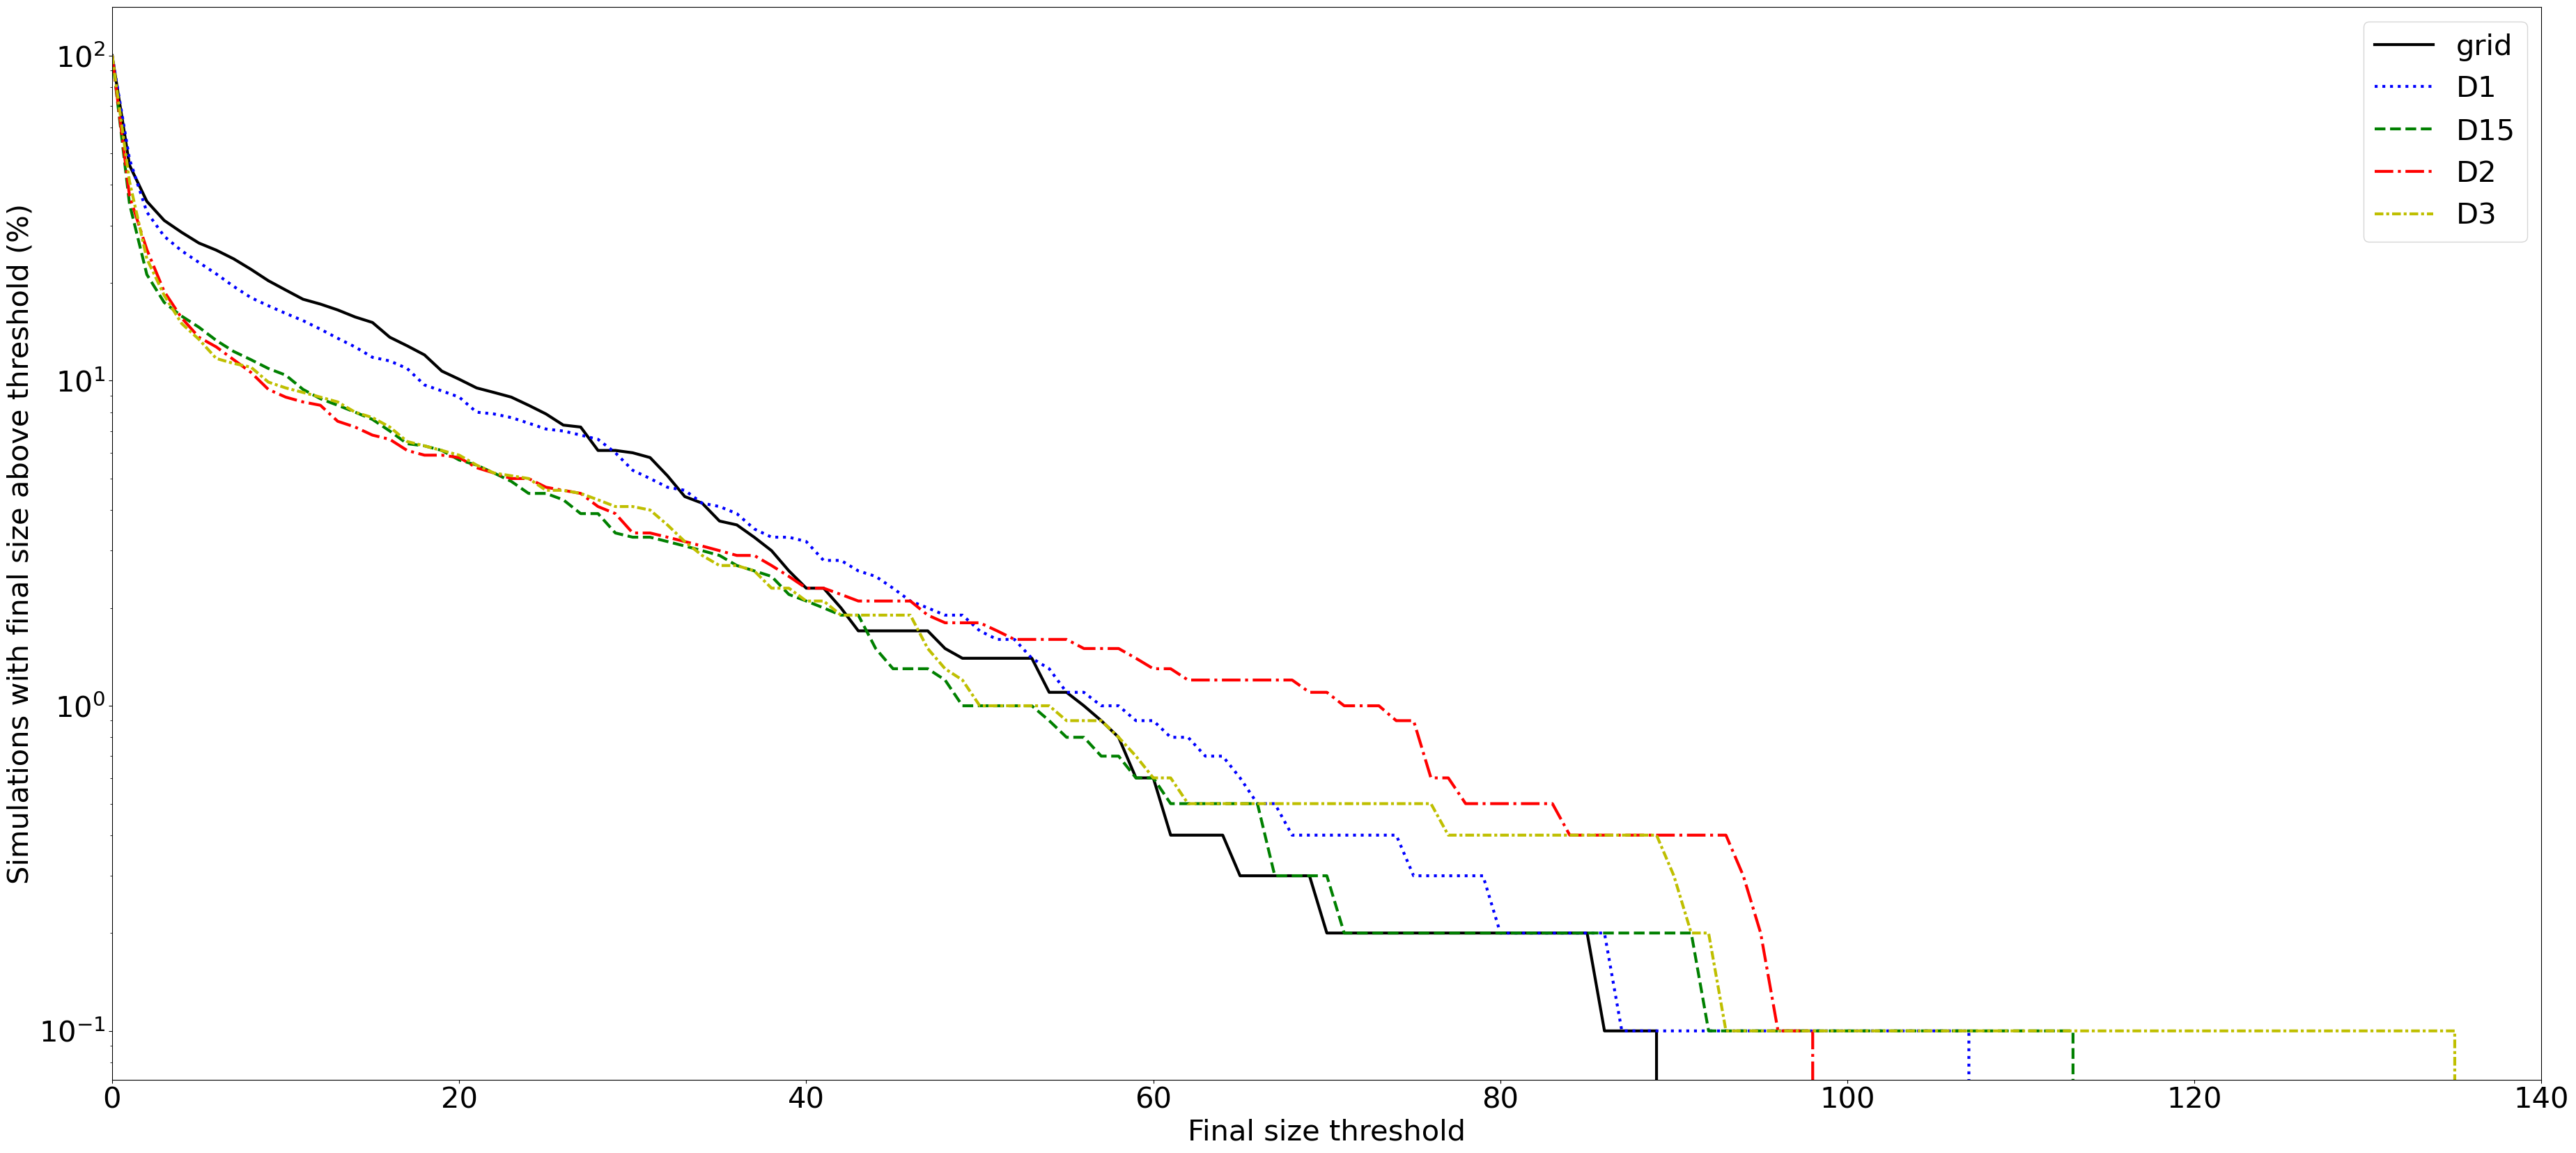

In [48]:
fig, ax = plt.subplots(1,1,figsize = (45,20))
colorstring = 'kbgry'
styles = ["solid","dotted","dashed","dashdot",(0, (3, 1, 1, 1))]
for i in range(len(networks)):
    n = networks[i]
    ax.plot(outbreaks_above["pre2021"][n]/10,colorstring[i],linewidth = 3,linestyle = styles[i])
#ax[0].set_ylim([0,45])
ax.set_xlim([0,140])
ax.set_ylabel("Simulations with final size above threshold (%)")
ax.set_xlabel("Final size threshold")
ax.legend(networks)

ax.set_yscale("log")
#trans = mtransforms.ScaledTranslation(-1.5, 1, fig.dpi_scale_trans)
#ax[0].text(0.0, 1.0, "a)", transform=ax[0].transAxes + trans,
#            fontsize=60, va='bottom', fontfamily='serif')


plt.savefig("images//pre2021_threshold_plot.png",dpi = 200)

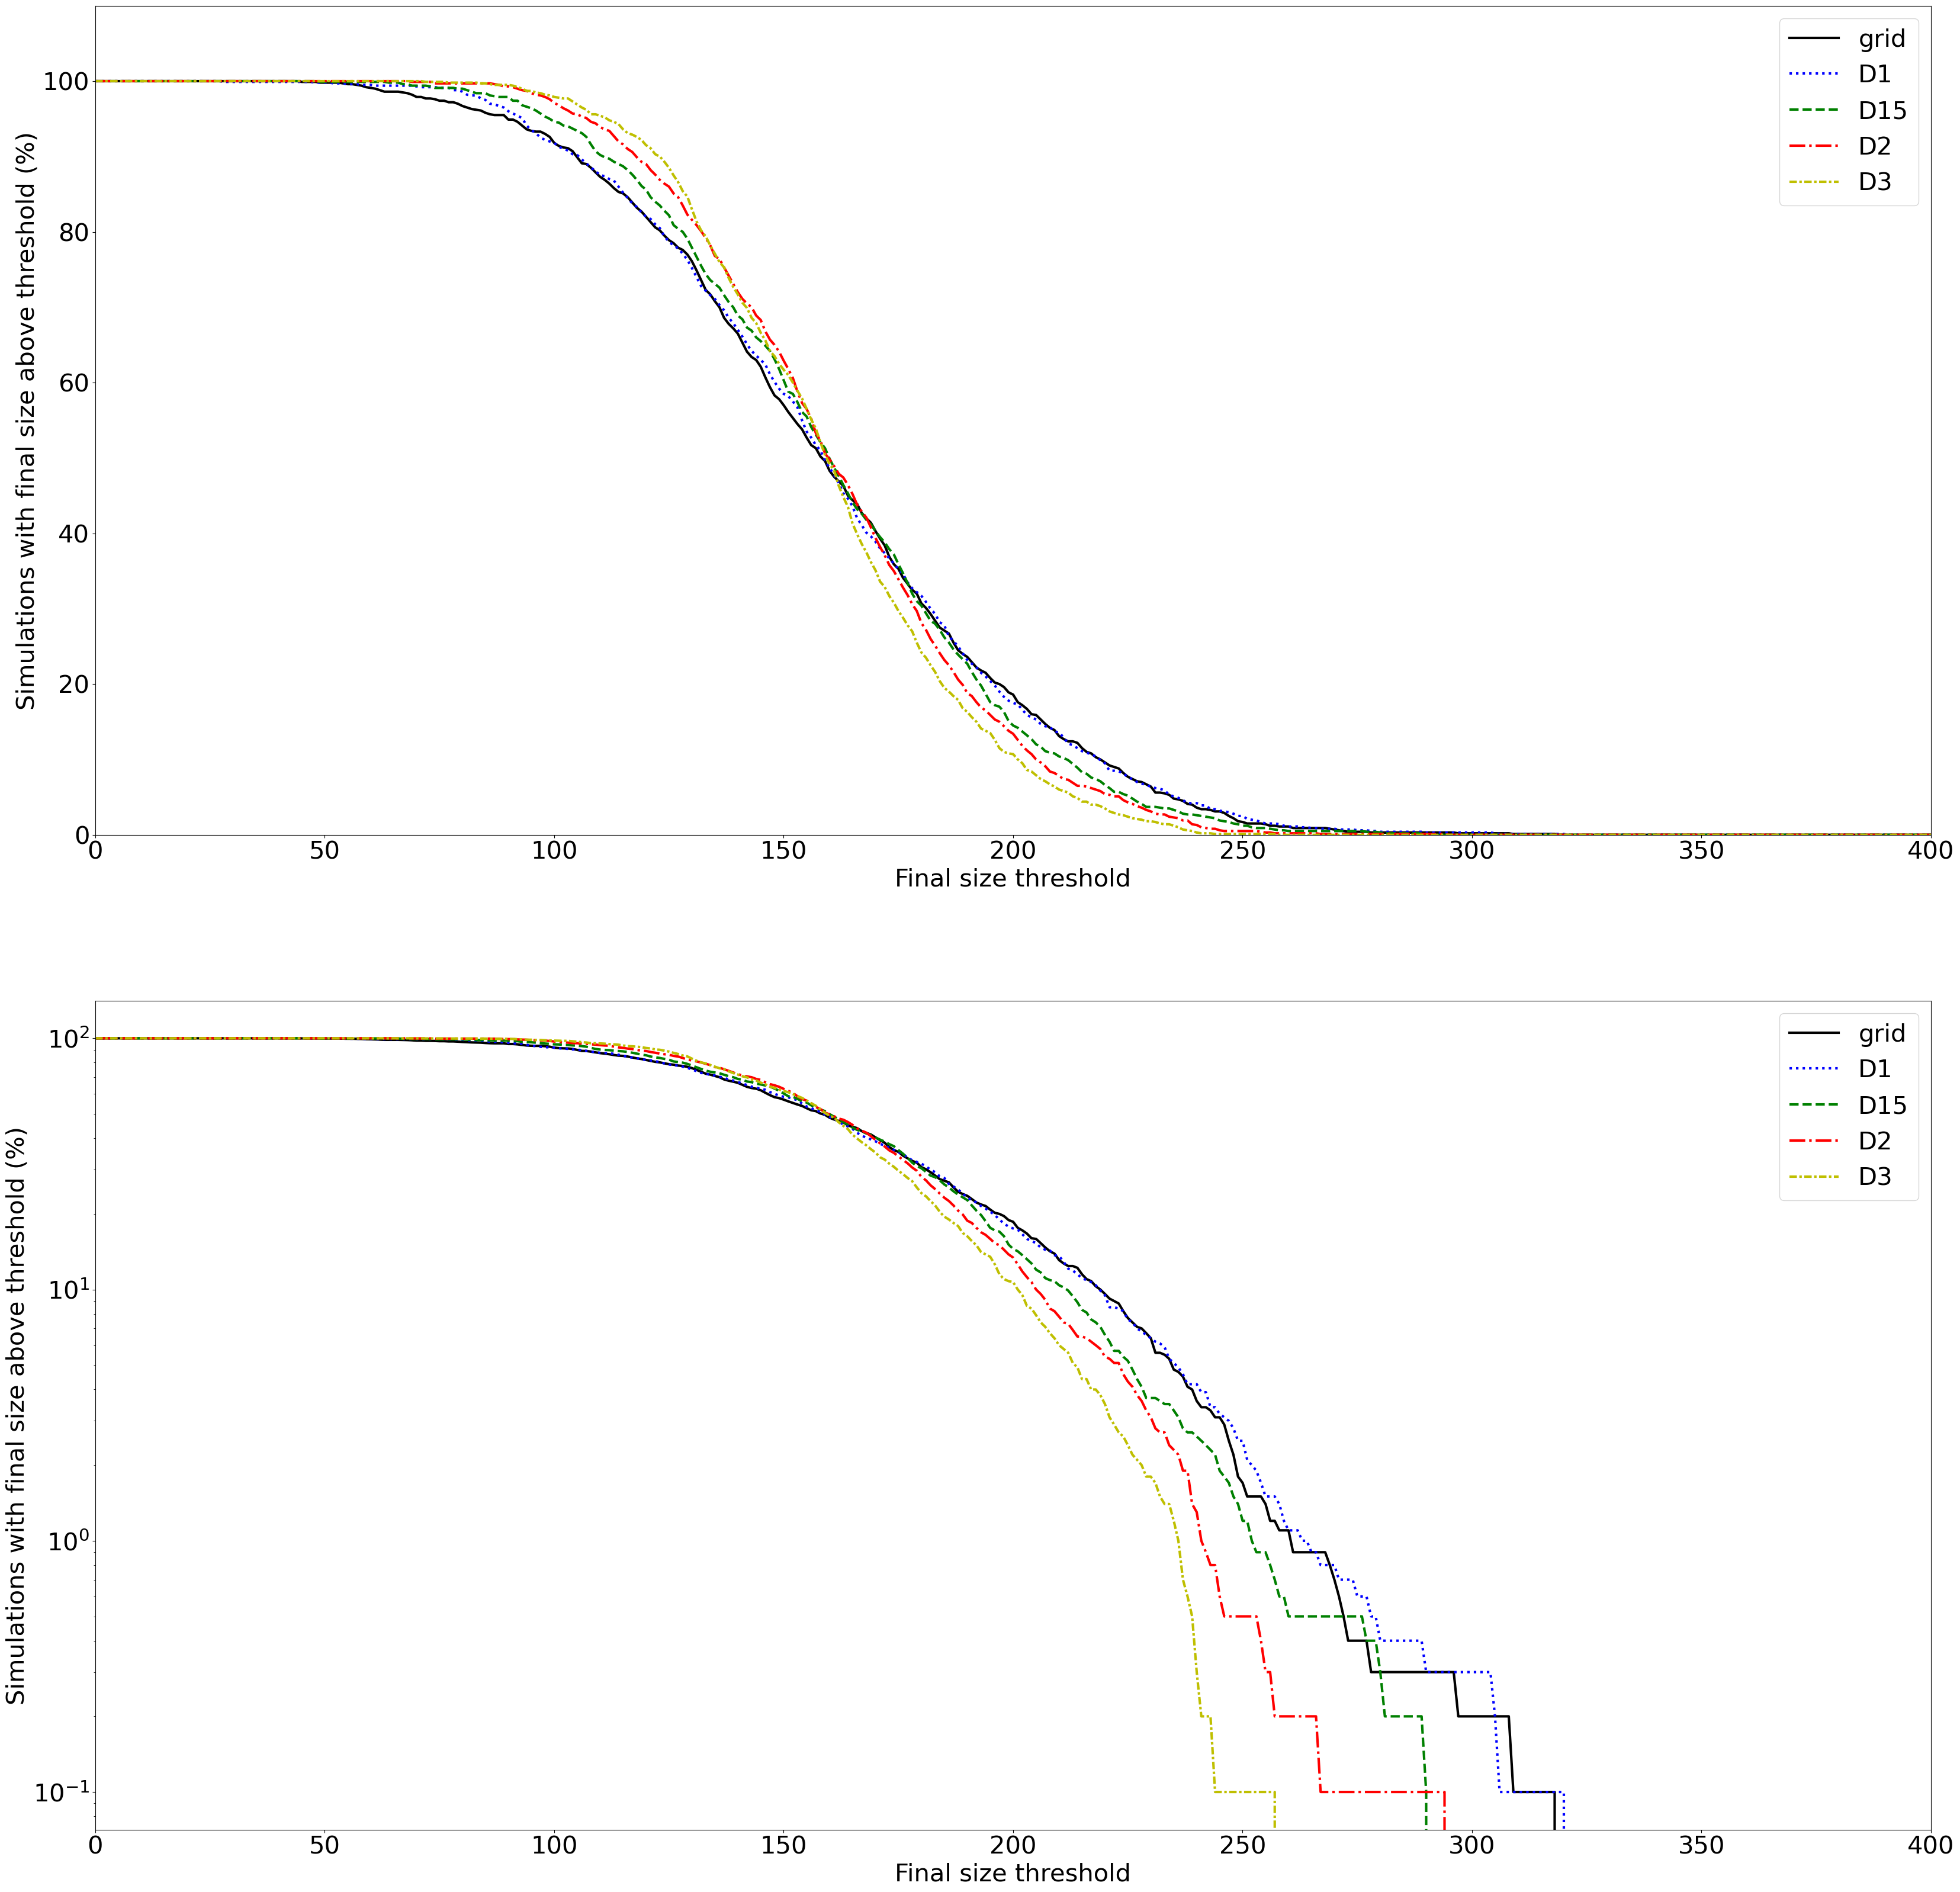

In [52]:
fig, ax = plt.subplots(2,1,figsize = (40,40))
colorstring = 'kbgry'
for i in range(len(networks)):
    n = networks[i]
    ax[0].plot(outbreaks_above["post2021"][n]/10,colorstring[i],linewidth = 3,linestyle = styles[i])
ax[0].set_ylim([0,110])
ax[0].set_xlim([0,400])
ax[0].set_ylabel("Simulations with final size above threshold (%)")
ax[0].set_xlabel("Final size threshold")
ax[0].legend(networks)


#ax[0].set_xlim([200,400])
#trans = mtransforms.ScaledTranslation(-1.5, 1, fig.dpi_scale_trans)
#ax[0].text(0.0, 1.0, "a)", transform=ax[0].transAxes + trans,
#            fontsize=60, va='bottom', fontfamily='serif')

for i in range(len(networks)):
    n = networks[i]
    ax[1].plot(outbreaks_above["post2021"][n]/10,colorstring[i],linewidth = 3,linestyle = styles[i])
#ax[1].set_ylim([0,100])
ax[1].set_xlim([0])
ax[1].set_yscale("log")
ax[1].set_ylabel("Simulations with final size above threshold (%)")
ax[1].set_xlabel("Final size threshold")
ax[1].legend(networks)
#ax[1].text(0.0, 1.0, "b)", transform=ax[1].transAxes + trans,
#            fontsize=60, va='bottom', fontfamily='serif')

plt.savefig("images//post2021_threshold_plot.png",dpi = 200)

# Temporal plot

Plots the mean number of cases by quarter for each of the transmission network types.

In [74]:
blocks = [0,92,182,273,365]

In [75]:
quarter_data = {n: {"pre2021":np.zeros([4,1000]),
                          "post2021":np.zeros([4,1000])} for n in networks}
                    

In [76]:
for net_type in tqdm(networks):
    if net_type == "grid":
        for period in list(final_size_data[net_type].keys()):
            for RNG_ID in range(1,101,1):
                for pop_ID in range(1,11,1):
                    filename = "sim_" + net_type + "_" + period + "_RNG" + str(RNG_ID).rjust(3,"0") + "_pop" + str(pop_ID).rjust(3,"0") + ".pkl"
                    with open("simulations\\"+filename,"rb") as f:
                        sim = load(f)
                    sim_number = (RNG_ID-1)*10+(pop_ID-1)
                    for q in range(4):
                        start = blocks[q]
                        end = blocks[q+1]
                        for j in range(start,end):
                            quarter_data[net_type][period][q][sim_number] += sim[0][j]
    else:
        for period in list(final_size_data[net_type].keys()):
            for net_ID in range(1,11,1):
                for RNG_ID in range(1,11,1):
                    for pop_ID in range(1,11,1):
                        filename = "sim_" + net_type + "_" + period + "_network" + str(net_ID).rjust(3,"0") + "_RNG" + str(RNG_ID).rjust(3,"0") + "_pop" + str(pop_ID).rjust(3,"0") + ".pkl"
                        with open("simulations\\"+filename,"rb") as f:
                            sim = load(f)
                        sim_number = (net_ID-1)*100+(RNG_ID-1)*10+(pop_ID-1)
                        for q in range(4):
                            start = blocks[q]
                            end = blocks[q+1]
                            for j in range(start,end):
                                quarter_data[net_type][period][q][sim_number] += sim[0][j]

100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


In [77]:
non_zero_quarter_data = {n: {"pre2021":[[quarter_data[n]["pre2021"][q][i] for i in range(1000) if quarter_data[n]["pre2021"][q][i]>0] for q in range(4)],
                             "post2021":[[quarter_data[n]["post2021"][q][i] for i in range(1000) if quarter_data[n]["post2021"][q][i]>0] for q in range(4)]} for n in networks}

In [78]:
for n in networks:
    for p in periods:
        for q in range(4):
            if non_zero_quarter_data[n][p][q] == []:
                non_zero_quarter_data[n][p][q] = [0]

In [79]:
means = {n:{p:[np.mean(non_zero_quarter_data[n][p][q]) for q in range(4) ] for p in periods} for n in networks}
medians = {n:{p:[np.median(non_zero_quarter_data[n][p][q]) for q in range(4)] for p in periods} for n in networks}
UQ = {n:{p:[np.quantile(non_zero_quarter_data[n][p][q],0.95)-means[n][p][q] for q in range(4)] for p in periods} for n in networks}
LQ = {n:{p:[means[n][p][q] - np.quantile(non_zero_quarter_data[n][p][q],0.05) for q in range(4)] for p in periods} for n in networks}

In [80]:
q1_means_pre = [means[n]["pre2021"][1-1] for n in networks]
q2_means_pre = [means[n]["pre2021"][2-1] for n in networks]
q3_means_pre = [means[n]["pre2021"][3-1] for n in networks]
q4_means_pre = [means[n]["pre2021"][4-1] for n in networks]

q1_medians_pre = [medians[n]["pre2021"][1-1] for n in networks]
q2_medians_pre = [medians[n]["pre2021"][2-1] for n in networks]
q3_medians_pre = [medians[n]["pre2021"][3-1] for n in networks]
q4_medians_pre = [medians[n]["pre2021"][4-1] for n in networks]

q1_Q_pre = np.zeros([2,5]) 
q2_Q_pre = np.zeros([2,5]) 
q3_Q_pre = np.zeros([2,5]) 
q4_Q_pre = np.zeros([2,5])

q1_Q_pre[1] = [UQ[n]["pre2021"][1-1] for n in networks]
q2_Q_pre[1] = [UQ[n]["pre2021"][2-1] for n in networks]
q3_Q_pre[1] = [UQ[n]["pre2021"][3-1] for n in networks]
q4_Q_pre[1] = [UQ[n]["pre2021"][4-1] for n in networks]

q1_Q_pre[0] = [LQ[n]["pre2021"][1-1] for n in networks]
q2_Q_pre[0] = [LQ[n]["pre2021"][2-1] for n in networks]
q3_Q_pre[0] = [LQ[n]["pre2021"][3-1] for n in networks]
q4_Q_pre[0] = [LQ[n]["pre2021"][4-1] for n in networks]

In [81]:
q1_means_post = [means[n]["post2021"][1-1] for n in networks]
q2_means_post = [means[n]["post2021"][2-1] for n in networks]
q3_means_post = [means[n]["post2021"][3-1] for n in networks]
q4_means_post = [means[n]["post2021"][4-1] for n in networks]

q1_medians_post = [medians[n]["post2021"][1-1] for n in networks]
q2_medians_post = [medians[n]["post2021"][2-1] for n in networks]
q3_medians_post = [medians[n]["post2021"][3-1] for n in networks]
q4_medians_post = [medians[n]["post2021"][4-1] for n in networks]

q1_Q_post = np.zeros([2,5]) 
q2_Q_post = np.zeros([2,5]) 
q3_Q_post = np.zeros([2,5]) 
q4_Q_post = np.zeros([2,5])

q1_Q_post[1] = [UQ[n]["post2021"][1-1] for n in networks]
q2_Q_post[1] = [UQ[n]["post2021"][2-1] for n in networks]
q3_Q_post[1] = [UQ[n]["post2021"][3-1] for n in networks]
q4_Q_post[1] = [UQ[n]["post2021"][4-1] for n in networks]

q1_Q_post[0] = [LQ[n]["post2021"][1-1] for n in networks]
q2_Q_post[0] = [LQ[n]["post2021"][2-1] for n in networks]
q3_Q_post[0] = [LQ[n]["post2021"][3-1] for n in networks]
q4_Q_post[0] = [LQ[n]["post2021"][4-1] for n in networks]

In [ ]:
S = [sum(means[n]["post2021"]) for n in networks]

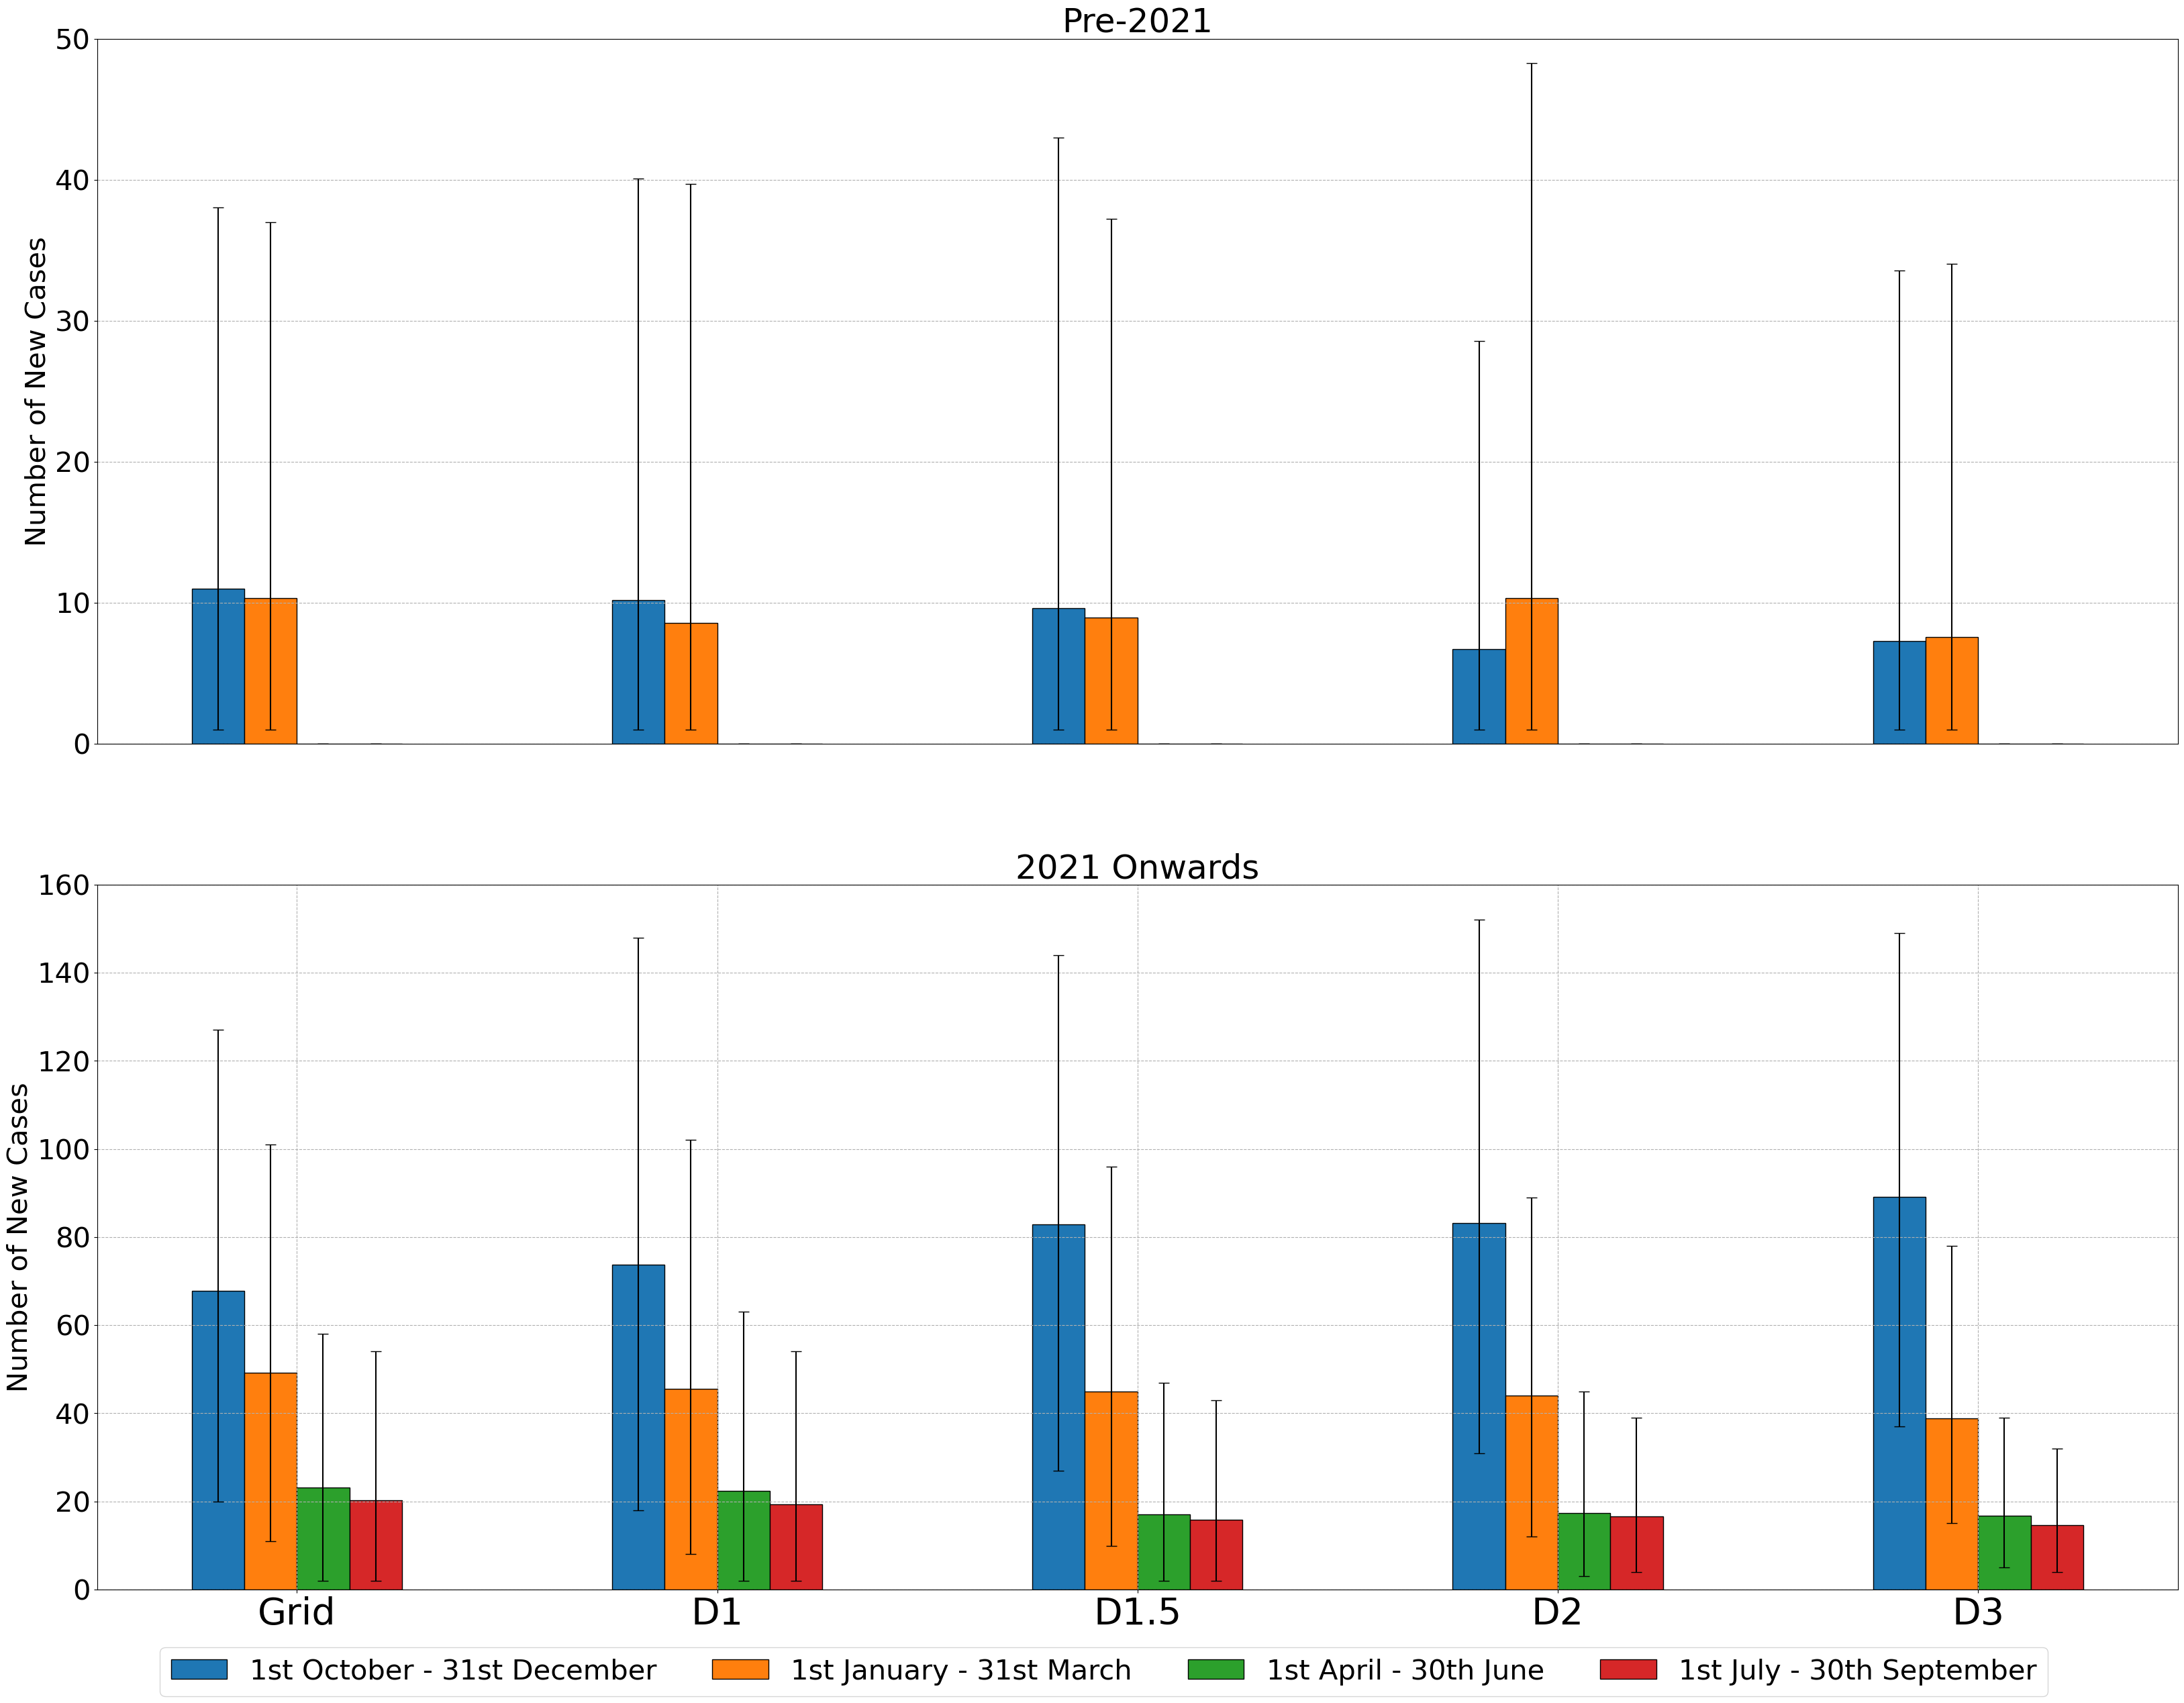

In [82]:
n=5
r = np.arange(n)
width = 0.125

fig,ax = plt.subplots(2,1,figsize=[40,30])
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')


  
ax[0].bar(r-width, q1_means_pre,yerr = q1_Q_pre,capsize = 6, width = width, edgecolor = 'black',
        label='1st October - 31st December')
ax[0].bar(r, q2_means_pre,yerr = q2_Q_pre,capsize = 6,  width = width, edgecolor = 'black',
        label='1st January - 31st March')
ax[0].bar(r+width, q3_means_pre,yerr = q3_Q_pre,capsize = 6,  width = width, edgecolor = 'black',
        label='1st April - 30th June')
ax[0].bar(r+2*width, q4_means_pre,yerr = q4_Q_pre,capsize = 6,  width = width, edgecolor = 'black',
        label='1st July - 30th September')

ax[0].set_xticks([])
ax[0].set_ylabel("Number of New Cases")
ax[0].set_ylim([0,50])
ax[0].set_title("Pre-2021")


plt.figlegend(ncol = 4,loc = "lower center",bbox_to_anchor=(0.5, 0.05))

ax[1].bar(r-width, q1_means_post,yerr = q1_Q_post,capsize = 6, width = width, edgecolor = 'black',
        label='1st October - 31st December')
ax[1].bar(r, q2_means_post,yerr = q2_Q_post,capsize = 6,  width = width, edgecolor = 'black',
        label='1st January - 31st March')
ax[1].bar(r+width, q3_means_post,yerr = q3_Q_post,capsize = 6,  width = width, edgecolor = 'black',
        label='1st April - 30th June')
ax[1].bar(r+2*width, q4_means_post,yerr = q4_Q_post,capsize = 6,  width = width, edgecolor = 'black',
        label='1st July - 30th September')

ax[1].set_xticks(r + width/2,['Grid','D1','D1.5','D2',"D3"],fontsize =  40)
ax[1].set_ylim([0,160])
ax[1].set_title("2021 Onwards")
ax[1].set_ylabel("Number of New Cases")




plt.savefig("images//temporal.png",dpi = 200)